**Exploring The Trends Within Obesity Level Based On Habits And Condition**

Team Member: Jiarui Li, Sijia Wei
Created: 8/14/2023

**Introduction and Motivation:**

Obesity is a widespread health concern that has garnered significant attention due to its increasing prevalence and its far-reaching impact on individuals and society.  The rise in obesity rates has prompted researchers, medical professionals, policymakers, and the general public to focus on understanding its causes, implications, and potential solutions.  The complex nature of obesity involves genetics, lifestyle choices, socio-economic conditions, and environmental factors.

Personal stories of individuals facing obesity-related challenges highlight the urgency of addressing this health crisis.  Witnessing the struggles and determination of those affected serves as a strong motivator for further exploration into the intricacies of obesity.  The strong connection between obesity and conditions like heart disease underscores the importance of tackling this issue to reduce the burden on healthcare systems and enhance individuals' quality of life.

Approaching the topic with empathy and a holistic perspective is vital.  By gaining insights into the various contributing factors of obesity and its consequences, we can work towards effective strategies for prevention, intervention, and support.

In [100]:
# Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy import stats as st

**Data Information**

The data I used can be downloaded from this link: 
https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records.

Here are some technical terms:
- Age Range: Data pertains to individuals aged between 14 and 61 from Mexico, Peru, and Colombia.
- Eating Habits Attributes:
  - FAVC: Frequent consumption of high-caloric food.
  - FCVC: Frequency of consumption of vegetables.
  - NCP: Number of main meals.
  - CAEC: Consumption of food between meals.
  - CH20: Consumption of water daily.
  - CALC: Consumption of alcohol.
- Physical Condition Attributes:
  - SCC: Calories consumption monitoring.
  - FAF: Physical activity frequency.
  - TUE: Time using technology devices.
  - MTRANS: Transportation used.
- Additional Variables:
  - Gender
  - Age
  - Height
  - Weight
- Labeling: All data labeled, resulting in the creation of class variable "NObesity" with values including Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III.
- Data Nature: Contains numerical and continuous data, suitable for analysis utilizing classification, prediction, segmentation, and association algorithms.

**Data Loading and Pre-processing**

In [101]:
# Define the column names
columns = ["Gender", "Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "NCP",
           "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS", "NObeyesdad"]

# Read the CSV file into a DataFrame using the defined column names
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv", names=columns)

# Drop the first row (header row)
df = df.drop(0)

# Convert columns to desired data types and round float columns to integers
df["Age"] = df["Age"].astype(float).round().astype(int)
df["Weight"] = df["Weight"].astype(float).round().astype(int)
df["FCVC"] = df["FCVC"].astype(float).round().astype(int)

# Display the first 10 rows of the DataFrame
df.head(10)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
2,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
3,Male,23,1.8,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
4,Male,27,1.8,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
5,Male,22,1.78,90,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
6,Male,29,1.62,53,no,yes,2,3,Sometimes,no,2,no,0,0,Sometimes,Automobile,Normal_Weight
7,Female,23,1.5,55,yes,yes,3,3,Sometimes,no,2,no,1,0,Sometimes,Motorbike,Normal_Weight
8,Male,22,1.64,53,no,no,2,3,Sometimes,no,2,no,3,0,Sometimes,Public_Transportation,Normal_Weight
9,Male,24,1.78,64,yes,yes,3,3,Sometimes,no,2,no,1,1,Frequently,Public_Transportation,Normal_Weight
10,Male,22,1.72,68,yes,yes,2,3,Sometimes,no,2,no,1,1,no,Public_Transportation,Normal_Weight


Certain data is currently in string format, which can be a bit unwieldy for effective organization. Moreover, we're dealing with float numbers that tend to complicate calculations. However, fear not! We're about to whip things into shape and make this data much more manageable. Let's dive in and tidy things up!

In [102]:
# Transforming Categorical Data

# Converting gender to numerical values: 0 for Female and 1 for Male
df["Gender"] = df["Gender"].apply(lambda x: 0 if x == "Female" else 1)

# Converting family history response to binary: 1 for Yes and 0 for No
df["family_history_with_overweight"] = df["family_history_with_overweight"].apply(lambda x: 1 if x == "yes" else 0)

# Converting dietary habits: 1 for Yes and 0 for No
df["FAVC"] = df["FAVC"].apply(lambda x: 1 if x == "yes" else 0)
df["SMOKE"] = df["SMOKE"].apply(lambda x: 1 if x == "yes" else 0)
df["SCC"] = df["SCC"].apply(lambda x: 1 if x == "yes" else 0)

# Converting mode of transportation to binary: 1 for Walking and 0 for Vehicle
df["MTRANS"] = df["MTRANS"].apply(lambda x: 1 if x == "Walking" else 0)

# Mapping Obesity Level Labels

# Defining a mapping for obesity levels based on their categories
label_mapping = {
    "Normal_Weight": 0,
    "Insufficient_Weight": 0,
    "Overweight_Level_I": 0.5,
    "Overweight_Level_II": 0.5,
    "Obesity_Type_I": 1,
    "Obesity_Type_II": 2,
    "Obesity_Type_III": 3
}

# Applying the label mapping using a lambda function
df["NObeyesdad"] = df["NObeyesdad"].apply(lambda x: label_mapping.get(x, x))

# Mapping CAEC and CALC Responses

# Mapping labels for CAEC and CALC responses to numerical values
label_mapping = {
    "no": 0,
    "Sometimes": 1,
    "Frequently": 2,
    "Always": 3,
}

# Applying the label mapping to CAEC and CALC using a lambda function
df["CAEC"] = df["CAEC"].apply(lambda x: label_mapping.get(x, x))
df["CALC"] = df["CALC"].apply(lambda x: label_mapping.get(x, x))

# Displaying the first 20 rows of the transformed DataFrame
df.head(20)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,0,21,1.62,64,1,0,2,3,1,0,2,0,0,1,0,0,0.0
2,0,21,1.52,56,1,0,3,3,1,1,3,1,3,0,1,0,0.0
3,1,23,1.8,77,1,0,2,3,1,0,2,0,2,1,2,0,0.0
4,1,27,1.8,87,0,0,3,3,1,0,2,0,2,0,2,1,0.5
5,1,22,1.78,90,0,0,2,1,1,0,2,0,0,0,1,0,0.5
6,1,29,1.62,53,0,1,2,3,1,0,2,0,0,0,1,0,0.0
7,0,23,1.5,55,1,1,3,3,1,0,2,0,1,0,1,0,0.0
8,1,22,1.64,53,0,0,2,3,1,0,2,0,3,0,1,0,0.0
9,1,24,1.78,64,1,1,3,3,1,0,2,0,1,1,2,0,0.0
10,1,22,1.72,68,1,1,2,3,1,0,2,0,1,1,0,0,0.0


Let's check how many data will we working on: 2111 rrows and 17 columns

In [103]:
df.shape

(2111, 17)

Let's check if there is any missing data. If the data is not float or int, it is missing. Luckily, the data is complete.

In [104]:
missing = []
# loop through all rows in the dataframe with df.iterrows()
for i, row in df.iterrows():
    try:
        # check if each value in the row can be turned into a float
        [float(val) for val in list(row)]
    except:
        # if cannot be converted to a float, this row has invalid data.
        missing.append(i)
missing

[]

**Exploratory Data Analysis**

Now that we've refined and organized our obesity dataset, it's time to dive into the exciting realm of data exploration and visualization. By visually representing our data and employing statistical techniques, we can uncover intriguing patterns and insights that might remain hidden otherwise. This exploration is crucial for us to draw meaningful and substantiated conclusions.

Let's embark on our journey by creating a captivating correlation heatmap for our dataset. This heatmap will provide us with a holistic overview of the relationships between various attributes. It's like a sneak peek into the intricate web of connections within our data. To achieve this, we'll be using the Pearson (r) correlation coefficient, a numerical value ranging from -1 to 1. This coefficient encapsulates the linear correlation between two variables. A value of -1 or 1 signifies a perfect negative or positive correlation, respectively. While these ideal scenarios are rare in reality, values approaching these extremes hint at strong relationships.

An interesting aspect to note is the "mask" we've incorporated into our heatmap. This smart inclusion eliminates the redundant upper right portion of the heatmap, enhancing its clarity. Keep in mind that heatmaps you encounter elsewhere might have diverse color schemes and appearances. However, the real essence lies in comprehending the values behind the colors, which is what truly matters. So, let's journey onward, armed with this visualization tool, and uncover the hidden treasures within our data!

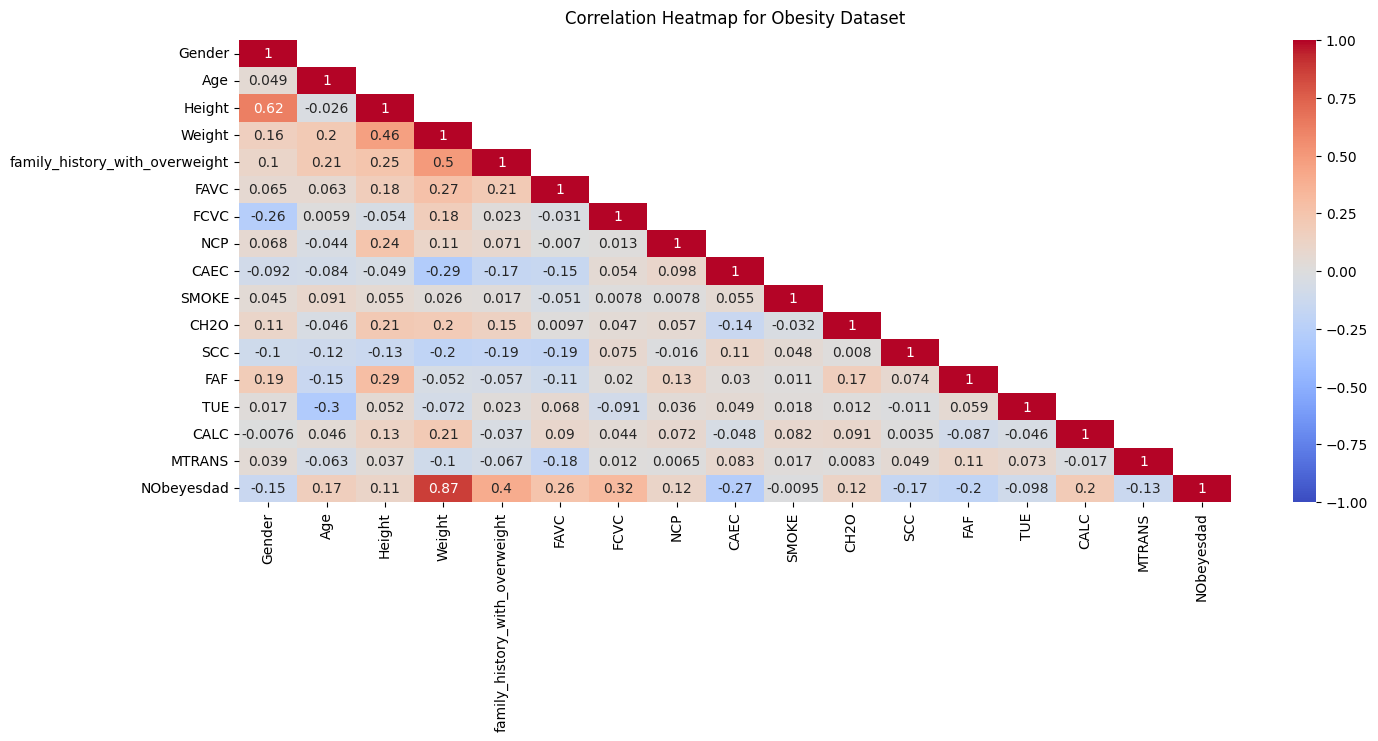

In [105]:
# Creating a Correlation Heatmap

# Set the figure size for the heatmap
plt.figure(figsize=(16, 6))

# Calculate the correlation matrix
corr = df.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(corr)
np.fill_diagonal(mask, False)

# Generate the heatmap using seaborn
heatmap = sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, mask=mask)

# Set the title and adjust its appearance
heatmap.set_title("Correlation Heatmap for Obesity Dataset", fontdict={"fontsize": 12}, pad=12)

# Display the heatmap
plt.show()

Examining the heatmap, a wealth of insights can be gleaned. It enables us to delve into diverse linear correlations, such as the relationship between age and obesity level, where the coefficient stands at 0.17.

To embark on a deeper exploration and extract richer insights, it's imperative that we delve further into our observations. Focusing our attention on the age-obesity level connection, let's unravel more intriguing aspects.

Our next endeavor involves depicting the distribution of obesity levels across various age groups. The initial step is segmenting years into distinct numerical bins, considering their quantitative nature. Grouping data proves immensely valuable, facilitating targeted observations for specific data segments and facilitating meaningful comparisons. Upon scrutinizing the unique ages, it becomes evident that they span a 40-year range. To capture this effectively, we can conveniently establish four bins, each spanning a decade. The meticulous grouping of data is accomplished through `pd.groupby()`, while `pd.cut()` expertly separates ages into the designated bins. With the foundational work in place, we are poised to create visual representations of the obesity level distribution within each age group.

In [106]:
# Extracting Unique Age Values

# Obtain a sorted array of unique age values
allAge = df["Age"].sort_values().unique()

# Display the array containing unique age values
allAge

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 51, 52, 55, 56, 61])

In [107]:
# Checking the size
allAge.size

40

In [108]:
# Grouping Data by Age Ranges

# Define labels for age ranges
labels = ["Ages 14 to 23", "Ages 24 to 33", "Ages 34 to 43", "Ages 44 to 61"]

# Define bins for age ranges
bins = [14, 24, 34, 44, 61]

# Group the dataset by age ranges using pd.cut()
ages = df.groupby(pd.cut(df["Age"], bins))

# Initialize an empty list to store DataFrames for each age group
age_dfs = []

# Loop through the age groups and print the length of each group
for i, age in enumerate(ages.groups.keys()):
    curr = ages.get_group(age)
    age_dfs.append(curr)
    print(f"Length of bin {i + 1} ({labels[i]}): {len(curr)}")

Length of bin 1 (Ages 14 to 23): 1333
Length of bin 2 (Ages 24 to 33): 598
Length of bin 3 (Ages 34 to 43): 162
Length of bin 4 (Ages 44 to 61): 17


With a positive Pearson correlation coefficient of 0.17, we can anticipate that obesity level should increase as the age groups progress. This positive coefficient suggests a tendency for obesity level to rise in tandem with increasing age, although it may not be that strong. To validate this hypothesis, let's visualize the distributions of heart rate across different age groups.

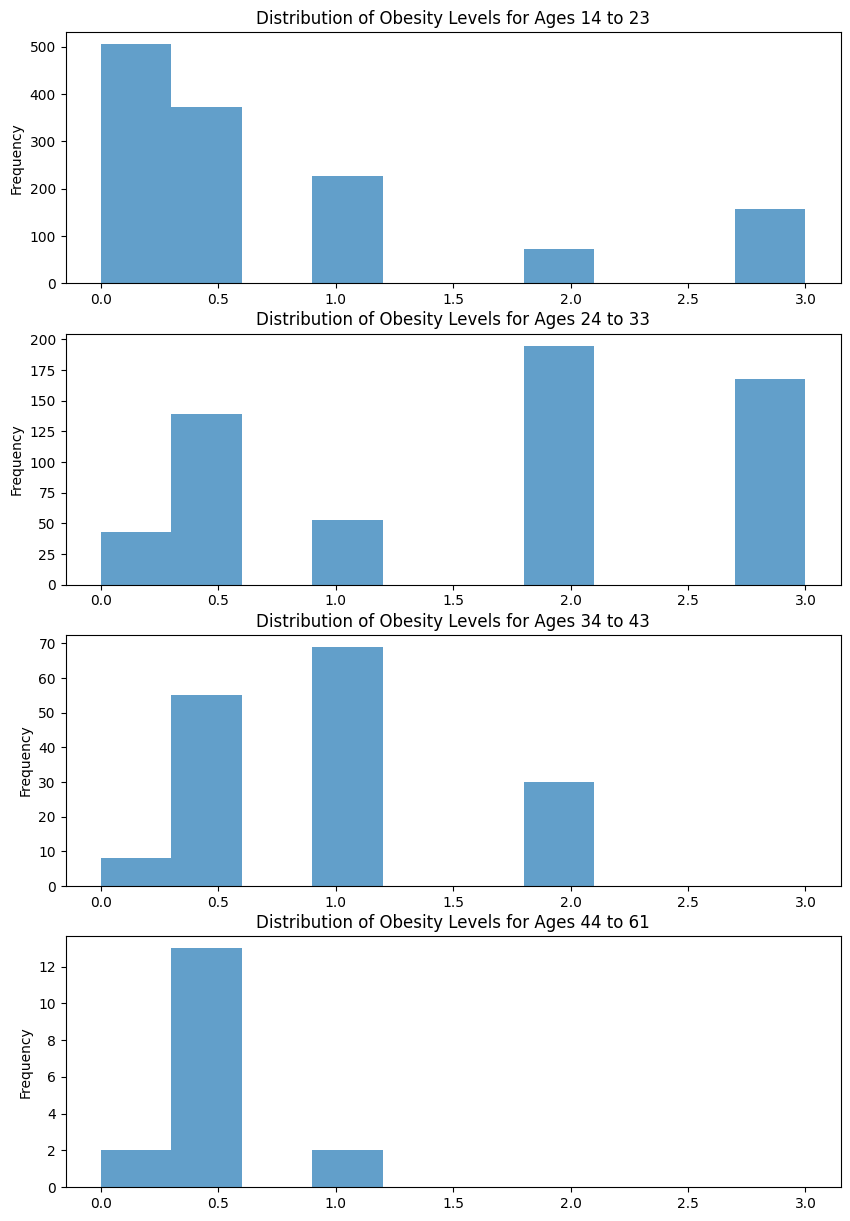

In [109]:
# Calculate the minimum and maximum obesity levels
min_obesity = np.min(df["NObeyesdad"])
max_obesity = np.max(df["NObeyesdad"])

# Create subplots
fig, axs = plt.subplots(4, figsize=(10, 15))

# Iterate through age groups and plot the distributions
for i in range(4):
    axs[i].hist(age_dfs[i]["NObeyesdad"], range=(min_obesity, max_obesity), alpha=0.7, label=labels[i])
    axs[i].set(title=f"Distribution of Obesity Levels for {labels[i]}", ylabel="Frequency")

plt.show()

As anticipated, the observed linear correlation exhibits a degree of modesty, as evidenced by its coefficient value of 0.17. This nuanced correlation suggests a gradual trend where, with the increase of age, there is a corresponding, albeit minor, elevation in obesity levels.

Transitioning from the analysis of age versus obesity level, our attention now turns to the dynamic synergy between weight and obesity level. This shift in focus prompts us to recalibrate our expectations for this particular relationship. In contrast to the subtle influence of age observed earlier, we anticipate a more pronounced impact stemming from weight, thanks to its relatively robust correlation coefficient of 0.87. This heightened coefficient hints at a stronger connection between weight and obesity level, encouraging us to delve further into this exploration to unveil the intriguing relationship between the two.

Now, let's illuminate another illustrative example: the intricate interplay between weight and obesity level. This correlation stands out prominently, boasting a substantial coefficient value of 0.87. The sheer magnitude of this coefficient unmistakably signals a robust and noteworthy association between weight and obesity level. This remarkable coefficient not only underscores the significance of the relationship but also beckons us to delve into the depths of this connection, unearthing a wealth of intriguing insights in the process.

In [110]:
# Extracting Unique Weight Values

allWeight = df["Weight"].sort_values().unique()
allWeight

array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 147, 149, 150, 151, 152, 153, 154, 155, 156, 161, 165,
       173])

In [111]:
# Checking the size
allWeight.size

118

In [112]:
# Creating Weight Bins and Grouping Data
# Define labels and bin ranges for weight groups
labels = ["Weights 39 to 69", "Weights 70 to 89", "Weights 90 to 119", "Weights 120 to 139", "Weights 140 to 173"]
bins = [39, 69, 89, 119, 139, 173]

# Group the data based on weight bins
weights = df.groupby(pd.cut(df["Weight"], bins))
weights_dfs = []

# Iterate through the weight groups and gather data for each bin
for i, w in enumerate(weights.groups.keys()):
    curr = weights.get_group(w)
    weights_dfs.append(curr)
    print(f"Length of bin {i + 1} ({labels[i]}): {len(curr)}")

Length of bin 1 (Weights 39 to 69): 603
Length of bin 2 (Weights 70 to 89): 621
Length of bin 3 (Weights 90 to 119): 632
Length of bin 4 (Weights 120 to 139): 219
Length of bin 5 (Weights 140 to 173): 33


In this code snippet, we aim to visualize the distribution of obesity levels across different weight groups. The min and max functions are used to calculate the range of obesity levels. We then create a subplot arrangement for visualization, consisting of five subplots to correspond with the five weight groups. Within the loop, histograms of obesity levels are plotted for each weight group. The labels of the weight groups are applied to the subplots' titles, and the y-axis is labeled as "Frequency." The resulting plots provide insights into how obesity levels are distributed within distinct weight ranges.

Before we examine the plotted data, let's take a moment to anticipate the expected distribution trends. With an r coefficient of 0.87, we can predict that there is a strong positive correlation between weight and obesity level. This suggests that as weight increases, the likelihood of higher obesity levels also increases. Now, let's proceed to visualize the data and see if our anticipation aligns with the observed distribution patterns.

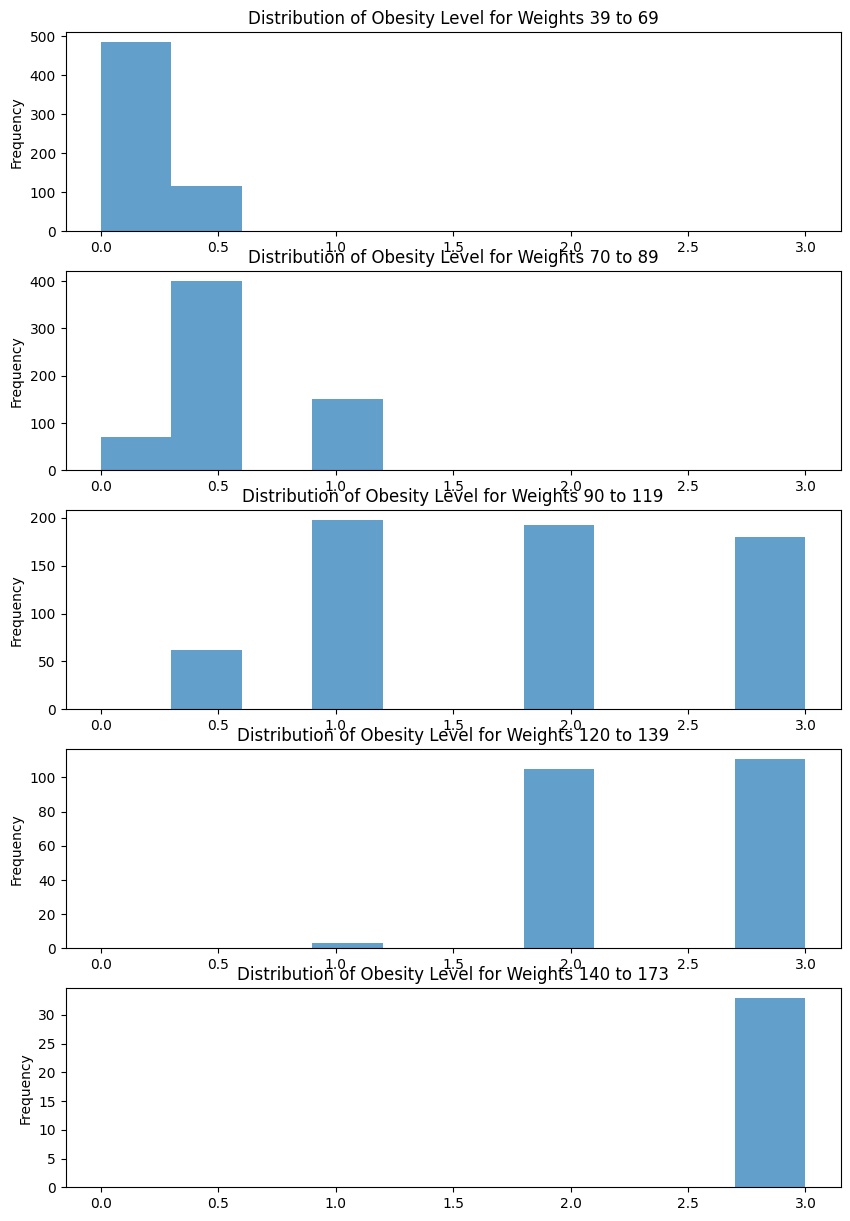

In [113]:
# Plotting Distribution of Obesity Level for Different Weight Groups
# Calculate minimum and maximum values for the obesity level
min_obesity = np.min(df["NObeyesdad"])
max_obesity = np.max(df["NObeyesdad"])

# Create subplots for visualizations
fig, axs = plt.subplots(5, figsize=(10, 15))

# Iterate through weight groups and plot histograms
for i in range(5):
    axs[i].hist(weights_dfs[i]["NObeyesdad"], range=(min_obesity, max_obesity), alpha=0.7, label=labels[i])
    axs[i].set(title=f"Distribution of Obesity Level for {labels[i]}", ylabel="Frequency")

plt.show()

As predicted, we can see from the distributions that the obesity level increases as weight increases, which is consistent with the r coefficient we found for the values.

Let's shift our focus to exploring the connection between obesity levels and the frequency of consumption of vegetables (FCVC). The frequency of consuming vegetables can be indicative of dietary habits and overall nutritional choices, which might influence obesity levels.

Like age groups, FCVC also plays a crucial role in various health aspects, including obesity. Research consistently shows differences in health outcomes based on dietary behaviors. Our dataset provides an opportunity to examine whether FCVC is associated with distinct trends in obesity levels.

To investigate this, we will once again employ pd.groupby() to segregate data based on FCVC. By creating separate dataframes for different FCVC ranges, we can make direct comparisons between them. Our initial step involves plotting a double bar chart to depict the proportion of different obesity levels for various FCVC groups. This visualization aims to provide insights into potential associations between vegetable consumption frequency and obesity levels.

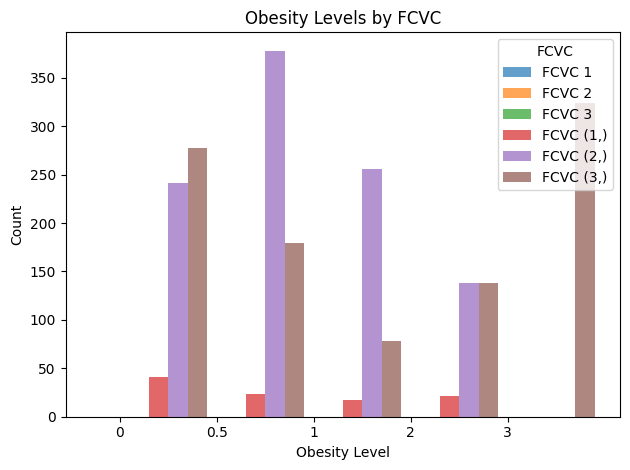

In [114]:
# Create subsets based on FCVC values
fcvc_groups = df.groupby(["FCVC"])

# Define obesity levels and initialize counts
obesity_levels = [0, 0.5, 1, 2, 3]
obesity_counts = {fcvc_value: np.zeros(len(obesity_levels)) for fcvc_value in [1, 2, 3]}

# Count the occurrences of each obesity level in each subset
for fcvc_value, fcvc_df in fcvc_groups:
    # Count the occurrences of each obesity level for the current FCVC group
    fcvc_counts = fcvc_df["NObeyesdad"].value_counts().reindex(obesity_levels, fill_value=0)
    obesity_counts[fcvc_value] = fcvc_counts.values

# Plot the data
fig, ax = plt.subplots()

x_axis = np.arange(len(obesity_levels))
bar_width = 0.2

for i, fcvc_value in enumerate(obesity_counts.keys()):
    # Offset the x position for each FCVC group's bar to avoid overlap
    ax.bar(x_axis + (i - 1) * bar_width, obesity_counts[fcvc_value], width=bar_width, alpha=0.7, label=f"FCVC {fcvc_value}")

ax.set(title="Obesity Levels by FCVC", xlabel="Obesity Level", ylabel="Count")
ax.set_xticks(x_axis)
ax.set_xticklabels(obesity_levels)
ax.legend(title="FCVC")

plt.tight_layout()
plt.show()

The observed distribution doesn't strongly indicate a significant relationship between the frequency of consumption of vegetables (FCVC) and obesity level. As evident from the plotted data, the distribution appears relatively even across the different obesity levels. This observation suggests that there isn't a pronounced trend linking higher or lower vegetable consumption frequency to specific obesity levels. While the relationship between FCVC and obesity level might not be readily apparent, further statistical analysis could help us uncover any potential subtleties or interactions that might be at play in this context.

Let's now shift our focus to exploring the association between obesity levels and the presence of family history with overweight. The presence of a family history of overweight can potentially provide insights into genetic predispositions and shared lifestyle factors that might influence obesity levels.

Similar to age groups, family history with overweight is a significant factor in various health considerations, including obesity. Extensive research indicates that genetic and familial factors can contribute to an individual's susceptibility to obesity. Our dataset presents an opportunity to investigate whether family history with overweight is linked to distinctive patterns in obesity levels.

To investigate this connection, we will once again utilize the pd.groupby() function to segment our data based on family history with overweight values. By creating separate dataframes for different family history categories, we can directly compare their influence on obesity levels. Our initial step involves plotting a double bar chart that showcases the distribution of different obesity levels across the various family history groups. This visualization aims to uncover potential associations between family history with overweight and the prevalence of different obesity levels.

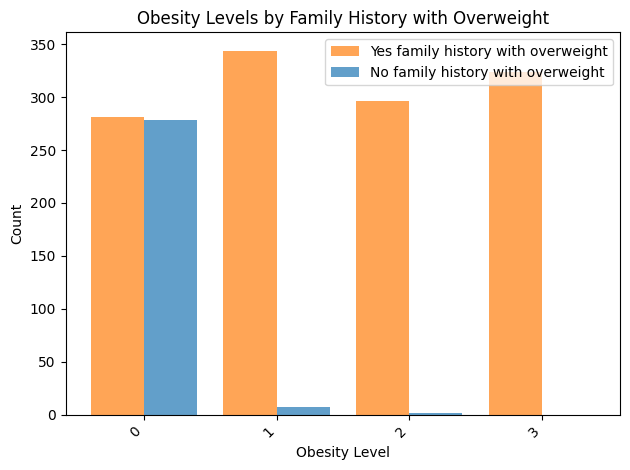

In [115]:
# Create subsets based on family history with overweight
fam_his = df.groupby(["family_history_with_overweight"])
yes_df = fam_his.get_group(1)
no_df = fam_his.get_group(0)

# Count the occurrences of each obesity level in each subset
obesity_levels = [0, 1, 2, 3]

# Count occurrences for 'Yes' family history
yes_counts = yes_df["NObeyesdad"].value_counts().reindex(obesity_levels, fill_value=0)

# Count occurrences for 'No' family history
no_counts = no_df["NObeyesdad"].value_counts().reindex(obesity_levels, fill_value=0)

# Plot the data
fig, ax = plt.subplots()

x_axis = np.arange(len(obesity_levels))
bar_width = 0.4

# Plot the bar chart for 'Yes' and 'No' family history
ax.bar(x_axis - bar_width/2, yes_counts, width=bar_width, color="tab:orange", alpha=0.7, label="Yes family history with overweight")
ax.bar(x_axis + bar_width/2, no_counts, width=bar_width, color="tab:blue", alpha=0.7, label="No family history with overweight")

ax.set(title="Obesity Levels by Family History with Overweight", xlabel="Obesity Level", ylabel="Count")
ax.set_xticks(x_axis)
ax.set_xticklabels(obesity_levels, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

The analysis of the distribution has unveiled a compelling and robust relationship between Family History with Overweight and obesity levels. The visual representation provided by the plot distinctly showcases a prominent trend—nearly all individuals classified under obesity have a significant Family History with Overweight. This substantial correlation prompts us to delve deeper into the underlying factors driving this connection, inviting further exploration and investigation into the intricate interplay between family history and the likelihood of obesity.

Returning to our exploration of age versus obesity level, let's now investigate whether gender plays a pivotal role in this relationship.

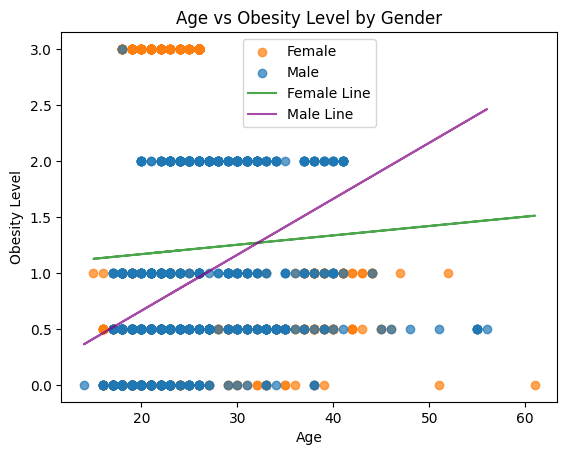

For women, obesity level increases by 0.008 per year on average
For men, obesity level increases by 0.050 per year on average


In [118]:
# Create a scatter plot for age vs obesity level by gender
fig, ax = plt.subplots(1)

# Separate data based on gender
genders = df.groupby(["Gender"])
female_df = genders.get_group(0)
male_df = genders.get_group(1)

# Extract x and y values for females and males
x1, y1 = female_df["Age"], female_df["NObeyesdad"]
x2, y2 = male_df["Age"], male_df["NObeyesdad"]

# Plot scatter points for females and males
ax.scatter(x1, y1, color="tab:orange", alpha=0.7, label="Female")
ax.scatter(x2, y2, color="tab:blue", alpha=0.7, label="Male")

# Set plot title and labels
ax.set(title="Age vs Obesity Level by Gender", xlabel="Age", ylabel="Obesity Level")

# Calculate linear regression lines for females and males
m1, b1 = np.polyfit(x1, y1, 1)
ax.plot(x1, m1*x1+b1, color="green", alpha=0.7, label="Female Line")

m2, b2 = np.polyfit(x2, y2, 1)
ax.plot(x2, m2*x2+b2, color="purple", alpha=0.7, label="Male Line")

# Add legend and display the plot
plt.legend()
plt.show()

# Display the average increase in obesity level per year for females and males
print(f"For women, obesity level increases by {abs(m1):.3f} per year on average")
print(f"For men, obesity level increases by {abs(m2):.3f} per year on average")


The scatter plot and linear regression lines presented in the visualization depict the intriguing relationship between age and obesity level, stratified by gender. By examining the data points representing women and men, we can discern distinct trends. The upward trajectory of the green "Female Line" signifies that, on average, the obesity level for women increases by approximately 0.008 units each year. In contrast, the purple "Male Line" reveals a steeper slope, indicating a more pronounced increase in obesity level for men—approximately 0.050 units per year on average.

**Summary**

This project embarked on an extensive exploration of the connections between diverse factors and obesity levels within the populations of Mexico, Peru, and Colombia.  Through rigorous data analysis and visualization, several key insights emerged.  The investigation into age and obesity level revealed a subtle correlation, suggesting that age might contribute incrementally to obesity.  Conversely, the study of weight and obesity level exhibited a more pronounced association, underscoring the substantial impact of weight on obesity outcomes.  Surprisingly, the frequency of consuming vegetables did not exhibit a strong linear relationship with obesity levels, indicating that the interplay between diet and obesity is nuanced.  However, a notable revelation came through the examination of family history with overweight, which showcased a robust connection with higher obesity levels.  Moreover, when gender was considered alongside age, distinctive gender-specific trends emerged—obesity levels for women exhibited a gradual increase of 0.008 units per year, while for men, the rise was more pronounced at around 0.050 units per year.  These findings collectively contribute crucial insights for health practitioners, researchers, and policymakers striving to design targeted interventions and strategies to address obesity within these specific populations.